In [10]:
import scipy
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
import joblib
import matplotlib.pyplot as plt

In [83]:
window = 14
#Preprocess Data
df = pd.read_csv('AMD.csv')
scaler = MinMaxScaler()
columns = df.columns
scaled = pd.DataFrame(scaler.fit_transform(df),columns = columns)

#Creating Sequences
x,y = [],[]
for i in range(window,len(scaled)):
    x.append(scaled.iloc[i-window:i].values)
    y.append(scaled['volatility'].iloc[i])
x,y = np.array(x),np.array(y)
split_index = int(0.8 * len(x))
X_train, X_test = x[:split_index], x[split_index:]
Y_train, Y_test = y[:split_index], y[split_index:]
df

,5. adjusted close,6. volume,Returns,volatility,SMA,Real Upper Band,Real Middle Band,Real Lower Band,ATR
0,13.565,2810300.0,1.043462,1.422921,11.971071,14.7134,11.9711,9.2287,0.8843
1,13.470,1967800.0,0.992997,1.386233,12.198929,14.8705,12.1989,9.5273,0.8568
2,13.405,2415600.0,0.995174,1.344850,12.395357,14.9872,12.3954,9.8035,0.8403
3,13.625,3166200.0,1.016412,1.237666,12.631786,15.0171,12.6318,10.2465,0.8228
4,13.845,1880400.0,1.016147,1.130614,12.861786,15.0408,12.8618,10.6828,0.8133
...,...,...,...,...,...,...,...,...,...
6214,134.820,76089361.0,1.017509,9.274015,144.437143,162.3105,144.4371,126.5638,8.7382
6215,130.180,64455613.0,0.965584,8.924747,142.347857,159.5481,142.3479,125.1477,8.6384
6216,128.670,54676492.0,0.988401,8.726337,140.412143,157.2300,140.4121,123.5943,8.5835
6217,136.320,49037454.0,1.059454,8.158656,139.322143,155.0459,139.3221,123.5984,8.5282


In [77]:
#model creation
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=X_train.shape[1:]))
model.add(LSTM(units=50))
model.add(Dropout(0.85))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')



C:\Users\amazi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [81]:
#model training
model.fit(X_train,Y_train,
          epochs=20,batch_size = 32,validation_data=(X_test,Y_test))

Epoch 1/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0025 - val_loss: 0.0134
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.0333e-04 - val_loss: 0.0117
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.1505e-04 - val_loss: 0.0106
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.1016e-04 - val_loss: 0.0096
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.1779e-04 - val_loss: 0.0091
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.2026e-04 - val_loss: 0.0064
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.6478e-04 - val_loss: 0.0073
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.1431e-04 - val_loss: 0.0047
Epoch 9/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.1543e-04 - val_loss: 0.0051
Epoch 10/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.2976e-04 - val_loss: 0.0055
Epoch 11/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.2922e-04 - val_loss: 0.0036
Epoch 12/20


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


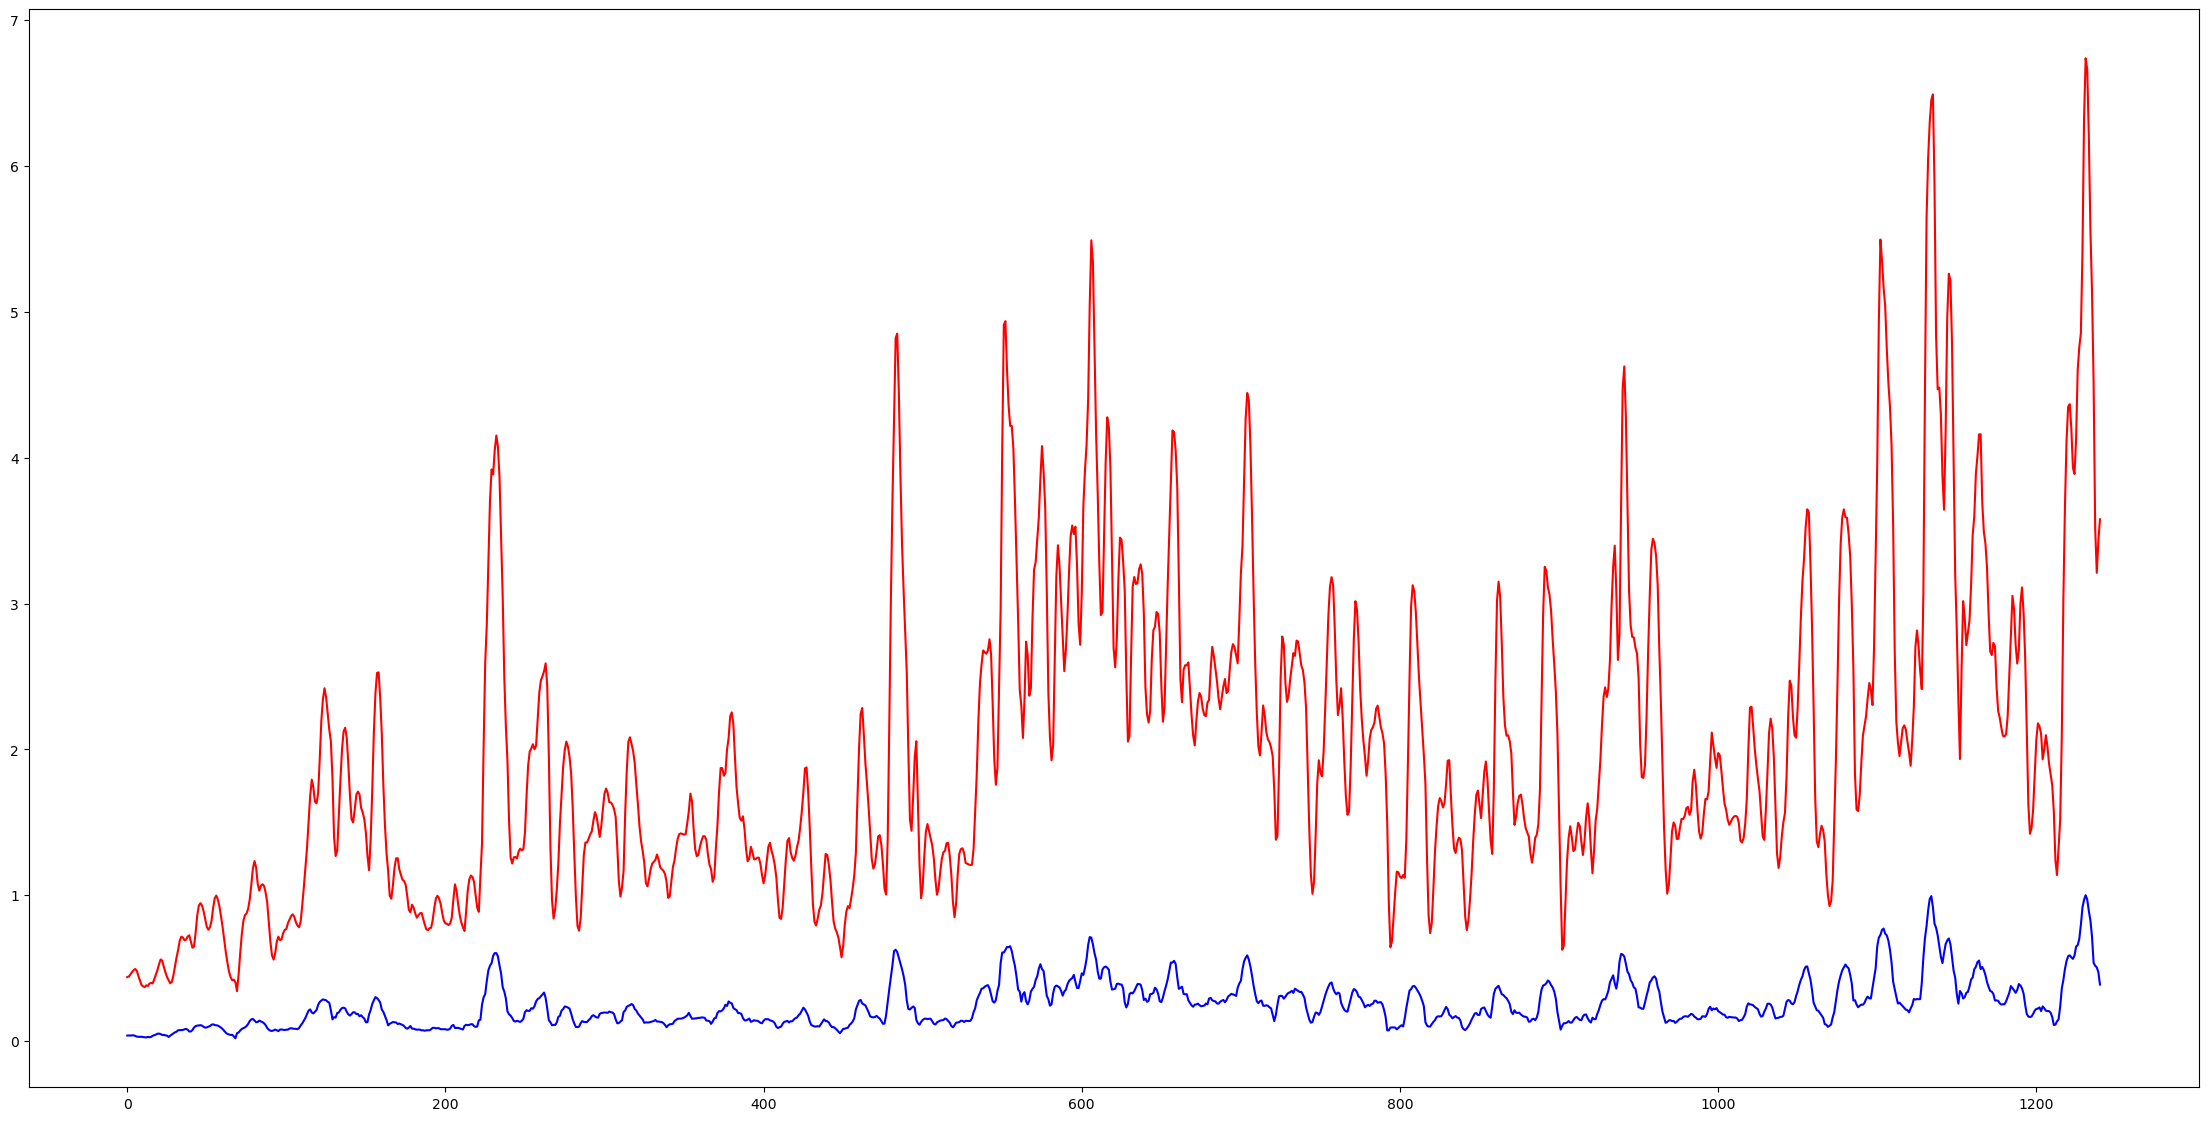

In [92]:
#eval
predictions_scaled = model.predict(X_test)

predictions_scaled_full = np.zeros((len(predictions_scaled), len(columns)))
predictions_scaled_full[:, -1] = predictions_scaled.flatten()
predictions = scaler.inverse_transform(predictions_scaled_full)[:, -1]

plt.figure(figsize=(28,14))

plt.plot(Y_test,color = 'blue',label='Actual Historical Volatility')
plt.plot(predictions, color='red', label='Predicted Historical Volatility')